# Variational Autoencoder

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/vae.jl

In [1]:
using Flux
using CuArrays
using Images
using Statistics
import Random: seed!

CuArrays.allowscalar(false)

┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/cavani/Workspace/julia-abc/software/julia-env/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


In [2]:
# Load data, binarise it, and partition into mini-batches of M.

import Flux.Data.MNIST

function load_mnist_binary(; use_gpu=true)
    X = float.(hcat(vec.(MNIST.images())...)) .> 0.5
    if use_gpu
        X = gpu(X)
    end
    return X
end

function make_batches(X, batch_size)
    num_examples = size(X, 2)
    data = [X[:, i] for i in Iterators.partition(1:num_examples, batch_size)]
    return data
end

X = load_mnist_binary()
M = 100
data = make_batches(X, M)

600-element Array{CuArray{Float32,2,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0

In [3]:
size(X)

(784, 60000)

In [4]:
length(data)

600

In [5]:
size(data[1])

(784, 100)

In [6]:
size(data[end])

(784, 100)

In [7]:
function sample_X(X, sample_size)
    indices = rand(1:size(X, 2), sample_size)
    X̃ = X[:, indices]
    return X̃
end

X̃′ = sample_X(X, 10)

784×10 CuArray{Float32,2,Nothing}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

In [8]:
################################# Define Model #################################

import Flux: functor

e = Float32(ℯ)

# Components of recognition model / "encoder" MLP.
struct Encoder
    A
    μ
    logσ
end

functor(g::Encoder) = (g.A, g.μ, g.logσ), y -> Encoder(y...)

function (g::Encoder)(X)
    A, μ, logσ = g.A, g.μ, g.logσ
    h = A(X)
    return μ(h), logσ(h)
end

function make_encoder(example_size, hidden_size, encoded_size; use_gpu=true)
    A = Dense(example_size, hidden_size, tanh)
    μ = Dense(hidden_size, encoded_size)
    logσ = Dense(hidden_size, encoded_size)
    
    if use_gpu
        A = gpu(A)
        μ = gpu(μ)
        logσ = gpu(logσ)
    end
    
    encoder = Encoder(A, μ, logσ)
    
    return encoder
end

# Generative model / "decoder" MLP.
function make_decoder(example_size, hidden_size, encoded_size; use_gpu=true)
    decoder = Chain(
        Dense(encoded_size, hidden_size, tanh),
        Dense(hidden_size, example_size, σ)
    )
    
    if use_gpu
        decoder = gpu(decoder)
    end
    
    return decoder
end

function z(μ, logσ; use_gpu=true)
    noise = randn(Float32, size(logσ)...)
    if use_gpu
        noise = gpu(noise)
    end
    return μ + (e .^ logσ) .* noise
end

# Image size, Latent dimensionality, # hidden units.
Dx = 28 ^ 2
Dh = 500
Dz = 5

g = make_encoder(Dx, Dh, Dz)
f = make_decoder(Dx, Dh, Dz);

In [9]:
θg = params(g)

for (i, θg′) in enumerate(θg)
    println(i, " : ", size(θg′))
end

1 : (500, 784)
2 : (500,)
3 : (5, 500)
4 : (5,)
5 : (5, 500)
6 : (5,)


In [10]:
θf = params(f)

for (i, θf′) in enumerate(θf)
    println(i, " : ", size(θf′))
end

1 : (500, 5)
2 : (500,)
3 : (784, 500)
4 : (784,)


In [11]:
x₁ = data[1]
μ₁, logσ₁ = g(x₁)

println("x₁    : ", size(x₁))
println("μ₁    : ", size(μ₁))
println("logσ₁ : ", size(logσ₁))

x₁    : (784, 100)
μ₁    : (5, 100)
logσ₁ : (5, 100)


In [12]:
z₁ = z(μ₁, logσ₁)

println("z₁    : ", size(z₁))

z₁    : (5, 100)


In [13]:
x₁′ = f(z₁)

println("x₁′   : ", size(x₁′))

x₁′   : (784, 100)


In [14]:
mse₁ = Flux.mse(x₁′, x₁)

println(mse₁)

0.25150895


In [15]:
####################### Define ways of doing things with the model. #######################

import Flux: binarycrossentropy

# log p(x|z) - conditional probability of data given latents.
log_p_x_z(x, z) = -sum(binarycrossentropy.(f(z), x))

# KL-divergence between approximation posterior and N(0, 1) prior.
kl_q_p(μ, logσ) = 0.5f0 * sum(e .^ (2f0 .* logσ) + μ .^ 2 .- 1f0 .- (2 .* logσ))

# Monte Carlo estimator of mean ELBO using M samples.
function L̄(X)
    μ′, logσ′ = g(X)
    z′ = z(μ′, logσ′)
    (log_p_x_z(X, z′) - kl_q_p(μ′, logσ′)) * 1 // M
end

seed!(42)
g = make_encoder(Dx, Dh, Dz)
f = make_decoder(Dx, Dh, Dz)
X̃ = sample_X(X, M)

-L̄(X̃) # 548.37317f0

548.37317f0

In [16]:
################################# Learn Parameters ##############################

import Flux: train!
import BSON: bson

θ = params(g, f)
optimizer = ADAM()
L2_f() = sum(x->sum(x .^ 2), params(f))
loss(X) = -L̄(X) + 0.01f0 * L2_f()

num_epochs = 200
early_stopping_patience = 10
learning_rate_schedule = 5

best_loss = nothing
last_improvement = 0

for epoch_idx in 1:num_epochs
    println("Epoch ", epoch_idx)
    @time train!(loss, θ, zip(data), optimizer)
    avg_loss = mean([-L̄(x) for x in data])

    println("Avg Loss : ", round(avg_loss; digits=4))

    # If this is the best metric we've seen so far, save the model out
    if best_loss === nothing || avg_loss ≤ best_loss
        println(" -> New best loss! Saving model out to vae_mnist.bson")
        bson("vae_mnist.bson", encoder = cpu(g), decoder = cpu(f), epoch = epoch_idx, loss = avg_loss)
        best_loss = avg_loss
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in N epochs, drop our learning rate:
    if epoch_idx - last_improvement ≥ learning_rate_schedule && optimizer.eta > 1e-6
        optimizer.eta /= 10.0
        println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement ≥ early_stopping_patience
        println(" -> We're calling this converged.")
        break
    end
    
    println()
end

Epoch 1
 57.196344 seconds (73.82 M allocations: 3.592 GiB, 2.32% gc time)
Avg Loss : 161.7681
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 2
 10.403250 seconds (7.01 M allocations: 298.742 MiB, 1.26% gc time)
Avg Loss : 150.1147
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 3
 10.359345 seconds (7.01 M allocations: 298.834 MiB, 1.24% gc time)
Avg Loss : 144.1504
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 4
 10.376736 seconds (7.01 M allocations: 298.784 MiB, 1.34% gc time)
Avg Loss : 140.1847
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 5
 10.378286 seconds (7.01 M allocations: 298.803 MiB, 1.32% gc time)
Avg Loss : 136.4023
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 6
 10.371215 seconds (7.01 M allocations: 298.788 MiB, 1.24% gc time)
Avg Loss : 134.4593
 -> New best loss! Saving model out to vae_mnist.bson

Epoch 7
 10.364986 seconds (7.01 M allocations: 298.877 MiB, 1.25% gc time)
Avg Loss : 133.2099

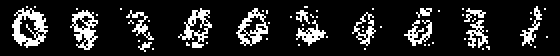

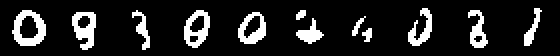

In [33]:
################################# Sample Output ##############################

import Distributions: Bernoulli, mode

# Sample from the learned model.
function model_sample_dist(; use_gpu=true)
    μ = zeros(Dz)
    logσ = zeros(Dz)
    if use_gpu
        μ = gpu(μ)
        logσ = gpu(logσ)
    end
    z′ = z(μ, logσ)
    x′ = f(z′)
    return Bernoulli.(cpu(x′))
end

img(x) = Gray.(reshape(x, 28, 28))

image_samples = [model_sample_dist() for i = 1:10]

display(hcat(img.(map(x -> rand.(x), image_samples))...))

display(hcat(img.(map(x -> mode.(x), image_samples))...))